In [578]:
import dpkt
import math
import pandas as pd
import matplotlib.pyplot as plt

# Part A
## Read Packets & Parse


In [662]:
class Packet:
    '''Encapsulate TCP's header fields of a packet from pcap.
    
    Attributes:
        source_port (int):  source port number
        dest_port (int):    destination port number
        sequence_num (int): sequence number
        ack_num (int):      acknowledgement number
        head_len(int):      header length
        urg (int):          urgent flag
        ack (int):          acknowledgement flag
        psh (int):          psh flag
        rst (int):          reset flag
        syn (int):          synchronize flag
        fin (int):          finish flag
        receive_win (int):  receive window
        checksum (int):     checksum
        urgent (int):       urgent data pointer
        scale (int):        window scaling size
        size (int):         the size of the whole packet, including data and all headers
        payload (int):      TCP payload
    '''
    
    def __init__(self, packet):
        '''Init a packet
        
        Args:
            packet(tuple): an element from dpkt.pcap.Reader.readpkts()
        '''
        self.time_stamp = packet[0]
        self.byte_info  = packet[1]
        self.size = len(packet[1])

        
    def parse_byte_info(self):
        '''Convert the byte format information of a packet into human readable fields
        '''
        self.source_port  = int.from_bytes(self.byte_info[34:36], byteorder='big')
        self.dest_port    = int.from_bytes(self.byte_info[36:38], byteorder='big')
        self.sequence_num = int.from_bytes(self.byte_info[38:42], byteorder='big')
        self.ack_num      = int.from_bytes(self.byte_info[42:46], byteorder='big')
        head_len          = int.from_bytes(self.byte_info[46:47], byteorder='big')
        self.head_len     = 4*(head_len>>4)
        flags             = int.from_bytes(self.byte_info[47:48], byteorder='big')
        self.fin = flags&1
        flags = flags>>1
        self.syn = flags&1
        flags = flags>>1
        self.rst = flags&1
        flags = flags>>1
        self.psh = flags&1
        flags = flags>>1
        self.ack = flags&1
        flags = flags>>1
        self.urg = flags&1
        self.receive_win = int.from_bytes(self.byte_info[48:50], byteorder='big')
        self.checksum    = int.from_bytes(self.byte_info[50:52], byteorder='big')
        self.urgent      = int.from_bytes(self.byte_info[52:54], byteorder='big')
        self.payload     = len(self.byte_info[34+packet.head_len:])
        
        
    def parse_window_scale(self):
        '''shift window size is typically 14. so the scaling is 2^14 = 16384
        '''
        shift = int.from_bytes(self.byte_info[73:74], byteorder='big')
        self.scale = 1<<shift

        
    def __str__(self):
        string = 'Source Port #  = {}\n'.format(self.source_port)
        string = string + 'Dest Port #    = {}\n'.format(self.dest_port)
        string = string + 'Sequence #     = {}\n'.format(self.sequence_num)
        string = string + 'Ackownledge #  = {}\n'.format(self.ack_num)
        string = string + 'Header length  = {}\n'.format(self.head_len)
        string = string + 'URG({}) ACK({}) PSH({})\n'.format(self.urg, self.ack, self.psh)
        string = string + 'RST({}) SYN({}) FIN({})\n'.format(self.rst, self.syn, self.fin)
        string = string + 'Receive window = {}\n'.format(self.receive_win)
        string = string + 'Checksum       = {}\n'.format(self.checksum)
        string = string + 'Urgent         = {}\n'.format(self.urgent)
        return string

In [660]:
packet = packets[8]
len(packet.byte_info[34+packet.head_len:])

1448

In [668]:
class Flow:
    '''Encapsulate a flow of packets from one port of sender to another port of receiver
    
    Attributes:
        __ID  (int):  private class member identification
        ID    (int):  identification of a flow
        port1 (int):  a port number
        port2 (int):  a port number
        flow  (list): a list of Packet
        loss_rate (float)
        throughput_emp (float): empirical throughput
        throughput_the (float): theoretical throuhput
        rtt (float): round trip time
        counter (int): count the number of packets in this flow
        scale (int):   window scaling size
        tda (int):     number of triple duplicate ack occurs
        timeout (int): number of timeout occurs
    '''
    __ID = 100
    
    def __init__(self):
        self.ID    = Flow.__ID
        Flow.__ID += 1
        self.port1 = -1
        self.port2 = -1
        self.flow  = []
        self.loss_rate      = -1
        self.throughput_emp = -1
        self.throughput_the = -1
        self.rtt     = -1
        self.counter = 0
        self.scale   = 1
        print('init a new flow {}'.format(self.ID))
        
    
    def __str__(self):
        return 'ID={}  port1={}  port2={}  # of packets={}'.format(self.ID, self.port1, self.port2, self.counter)
         
    
    def set_port(self, packet):
        self.port1 = packet.source_port
        self.port2 = packet.dest_port
        
    
    def get_packet(self, index):
        if index >= 0 and index < len(self.flow):
            return self.flow[index]
        else:
            return None
        
    
    def add_packet(self, packet):
        self.flow.append(packet)
        self.counter += 1
        
        
    def check_three_handshake(self):
        '''Return the index of the first packet after the three way handshake
        
        Return:
            (int) index
        '''
        index = 0
        first_seq  = -1
        second_seq = -1
        second_ack = -1
        third_seq  = -1
        third_ack  = -1
        for packet in self.flow:
            index += 1
            if getattr(packet, 'syn') == 1 and getattr(packet, 'ack') == 0:
                first_seq = getattr(packet, 'sequence_num')
                packet.parse_window_scale()
                self.scale = getattr(packet, 'scale')
            elif getattr(packet, 'syn') == 1 and getattr(packet, 'ack') == 1:
                second_seq = getattr(packet, 'sequence_num')
                second_ack = getattr(packet, 'ack_num')
                if second_ack != first_seq + 1:
                    first_seq  = -1
                    second_seq = -1
                    second_ack = -1
            elif getattr(packet, 'syn') == 0 and getattr(packet, 'ack') == 1:
                third_seq = getattr(packet, 'sequence_num')
                third_ack = getattr(packet, 'ack_num')
                if third_ack != second_seq + 1:
                    first_seq  = -1
                    second_seq = -1
                    second_ack = -1
                    third_seq  = -1
                    third_ack  = -1
                else:
                    break
        return index
    
    
    def print_first_2_transaction(self): 
        '''Part A (a): For the first 2 transactions after the TCP connection is set up 
           (from sender to receiver), get the values of the Sequence number, Ack number, 
           and Receive Window size. Explain these values.
        ''' 
        index = self.check_three_handshake()
        sender_1 = self.flow[index]
        sender_2 = self.flow[index+1]
        payload_1 = getattr(sender_1, 'payload')
        payload_2 = getattr(sender_2, 'payload')
        seq_1     = getattr(sender_1, 'sequence_num')
        seq_2     = getattr(sender_2, 'sequence_num')
        ack_1     = seq_1 + payload_1
        ack_2     = seq_2 + payload_2
        receiver_1 = None
        receiver_2 = None
        
        for packet in self.flow:
            ack = getattr(packet, 'ack_num')
            if ack == ack_1:
                receiver_1 = packet
                break
                
        for packet in self.flow:
            ack = getattr(packet, 'ack_num')
            if ack == ack_2:
                receiver_2 = packet
                break
        
        if receiver_1 == None or receiver_2 == None:
            print('Error!')
            return
        
        print('\n\n***Flow {}***'.format(self.ID))
        print('\nTransaction 1:')
        seq1 = getattr(sender_1, 'sequence_num')
        ack1 = getattr(sender_1, 'ack_num')
        rec1 = getattr(sender_1, 'receive_win')
        seq2 = getattr(receiver_1, 'sequence_num')
        ack2 = getattr(receiver_1, 'ack_num')
        rec2 = getattr(receiver_1, 'receive_win')
        print('Sender: sequence # = {}  acknowledge # = {}  receive window = {}'.format(seq1, ack1, rec1))
        print('I just a sent some data to you, starting at the ({0})th byte. \nThe next btye I anticipate to receive from you starts at the ({1})th byte. \nMy receive window size is {2} times {3}.'.format(seq1, ack1, rec1, self.scale))
        print('\nReceiver: sequence # = {}  acknowledge # = {}  receive window = {}'.format(seq2, ack2, rec2))
        print('I just a sent some data to you, starting at the ({0})th byte. \nThe next btye I anticipate to receive from you starts at the ({1})th byte. \nMy receive window size is {2} times {3}.'.format(seq2, ack2, rec2, self.scale)) 
        
        print('\nTransaction 2:')
        seq1 = getattr(sender_2, 'sequence_num')
        ack1 = getattr(sender_2, 'ack_num')
        rec1 = getattr(sender_2, 'receive_win')
        seq2 = getattr(receiver_2, 'sequence_num')
        ack2 = getattr(receiver_2, 'ack_num')
        rec2 = getattr(receiver_2, 'receive_win')
        print('Sender: sequence # = {}  acknowledge # = {}  receive window = {}'.format(seq1, ack1, rec1))
        print('I just a sent some data to you, starting at the ({0})th byte. \nThe next btye I anticipate to receive from you starts at the ({1})th byte. \nMy receive window size is {2} times {3}.'.format(seq1, ack1, rec1, self.scale))
        print('\nReceiver: sequence # = {}  acknowledge # = {}  receive window = {}'.format(seq2, ack2, rec2))
        print('I just a sent some data to you, starting at the ({0})th byte. \nThe next btye I anticipate to receive from you starts at the ({1})th byte. \nMy receive window size is {2} times {3}.'.format(seq2, ack2, rec2, self.scale)) 
      
        
    def compute_throughput(self):
        '''Compute the throughput for data sent from source to destination. 
           To estimate throughput count all data and headers. You need to 
           figure out how to define throughput in terms of what you are including as part of the throughput estimation.
        '''
        total_data = 0
        for packet in self.flow:
            total_data += getattr(packet, 'size')
            
        start = getattr(self.flow[0], 'time_stamp')
        end   = getattr(self.flow[self.counter-1], 'time_stamp')
        elapse = end - start
        self.throughput_emp = (total_data*8.0)/(elapse*1000000)
        print('***Flow {}***'.format(self.ID))
        print('Throughput is {0:1.5f} Mbps\n'.format(self.throughput_emp))
        
        
    def compute_loss_rate(self):
        '''Compute the loss rate for each flow. 
           Loss rate is the number of packets not received divided by the number of packets sent.
        '''
        seq_counter = {}
        for packet in self.flow:
            seq = getattr(packet, 'sequence_num')
            source_port = getattr(packet, 'source_port')  # packet's source port
            sender_port = self.port1                      # flow's sender
            if seq_counter.get(seq) and source_port == sender_port:
                seq_counter[seq] = seq_counter[seq] + 1
                #print(seq, seq_counter[seq])
            else:
                seq_counter[seq] = 1
                
        total_send = 0
        for counter in seq_counter.values():
            total_send += counter
        retransmission = total_send - len(seq_counter) - 1 
        print('***Flow {}***'.format(self.ID))
        print('# of loss is {}'.format(retransmission))
        print('# of packets send is {}'.format(len(self.flow)))
        self.loss_rate = retransmission*1.0/len(self.flow)
        print('Therefore, the loss rate is {0:1.6f}\n'.format(self.loss_rate))
        
        
    def estimateRTT(self):
        '''Estimate the average RTT. Now compare your empirical throughput from (b) 
           and the theoretical throughput (estimated using the formula derived in class). Explain your comparison.
        '''
        payload = 1448       # 1448 byte is the max amount of payload in a TCP segment
        sender_dic = {}      # stony brook  {seq --> packet}
        sender_dic_ret = {}  # packets that are retransmitted
        receiver_dic = {}    # washington   {ack --> packet}
        for packet in self.flow:
            source_port = getattr(packet, 'source_port')
            if source_port == self.port1:  # sender --> receiver
                seq = getattr(packet, 'sequence_num')
                if sender_dic.get(seq):    # retransmmision packets appear twice
                    sender_dic_ret[seq] = packet
                else:
                    sender_dic[seq] = packet
            else:                          # receiver --> sender
                ack = getattr(packet, 'ack_num')
                receiver_dic[ack] = packet
        
        for key in sender_dic_ret:  # when esitmating RTT, we do not consider the retransmission case
            sender_dic.pop(key)
            
        total_time = 0
        counter = 0
        for ack, ack_packet in receiver_dic.items():
            seq = ack - payload
            seq_packet = sender_dic.get(seq)
            if seq_packet:
                time2 = getattr(ack_packet, 'time_stamp')
                time1 = getattr(seq_packet, 'time_stamp')
                total_time += (time2 - time1)
                counter += 1
        self.rtt = total_time/counter
        print('***Flow {}***'.format(self.ID))
        print('Estimated RTT is {0:1.5f} second'.format(self.rtt))
        try:
            self.throughput_the = (math.sqrt(3/2)*1460*8)/(self.rtt*math.sqrt(self.loss_rate))
            print('Theoretical throughput is {0:1.5f} Mbps\n'.format(self.throughput_the/1000000))
        except ZeroDivisionError as ze:
            print('Theoretical throughput is infinity')
        except Exception as e:
            print(e)
            
            
         
    def compute_dta_timeout(self):
        '''Compute the number of times a retransmission occurred due to triple duplicate ack 
           and the number of time a retransmission occurred due to timeout 
           (as before, determine if you need to do it at the sender or the receiver)
        '''
        sender_dic = {}      # stony brook  {seq --> [packet]}
        receiver_dic = {}    # washington   {ack --> [packet]}
        for packet in self.flow:  # divide the packets in the flow into two dict
            source_port = getattr(packet, 'source_port')
            if source_port == self.port1:   # sender's packet
                seq = getattr(packet, 'sequence_num')
                packet_list = sender_dic.get(seq)
                if packet_list:
                    packet_list.append(packet)
                else:
                    sender_dic[seq] = [packet]
            else:                           # receiver's packet
                ack = getattr(packet, 'ack_num')
                packet_list = receiver_dic.get(ack)
                if packet_list:
                    packet_list.append(packet)
                else:
                    receiver_dic[ack] = [packet]
                    
        retransmit_dic = {}   # {seq --> [packet]}
        for seq, packet_list in sender_dic.items():  # get the retrasmitted packets
            if len(packet_list) > 1:
                retransmit_dic[seq] = packet_list
                
        total_retransmission = len(retransmit_dic) - 1   # minus the third handshake and the one right after it
        tda_counter = 0  # triple duplicate ack counter
        
        for seq, packet_list in retransmit_dic.items():
            ack = seq
            timestamp_1 = getattr(packet_list[0], 'time_stamp')  # from data, oberserve no retransmission twice
            timestamp_2 = getattr(packet_list[1], 'time_stamp')
            packet_list = receiver_dic.get(ack)
            if packet_list:
                ack_counter = 0
                for packet in packet_list:
                    timestamp = getattr(packet, 'time_stamp')
                    if timestamp > timestamp_1 and timestamp < timestamp_2:
                        ack_counter += 1
                    if ack_counter >= 3:    # Mark: issue here. one ack plus triple ack, so need to be bigger than 3
                        tda_counter += 1
                        break
                        
        self.tda = tda_counter
        self.timeout = total_retransmission - self.tda  # two reasons of retransmission: TDA or timeout
        print('***Flow {}***'.format(self.ID))
        print('# of triple duplicate ack = {}'.format(self.tda))
        print('# of timeout = {}\n'.format(self.timeout))
                

In [639]:
class FlowManager:
    '''Manage some flows
    
    Attributes:
        flow_list (list): an list(array) of Flow
        flow_info (dict): a dict { ID : (index, port1, port2) }
    '''
    
    def __init__(self):
        self.flow_list = []
        self.flow_info = {}
        
        
    def add_packet(self, packet):
        '''Add a packet to the flow it belongs to. 
           If the flow does not exit, then create a new one.
           
        Args:
            packet (Packet)
        '''
        index = self.where_is_packet(packet)
        if index == -1:  # this is a "new packet": the packet does not belong to any existed flow
            new_flow = Flow()
            new_flow.set_port(packet)
            new_flow.add_packet(packet)
            self.add_flow(new_flow)
        else:            # this packet belongs to an existed flow
            self.flow_list[index].add_packet(packet)
    
    
    def add_flow(self, flow):
        '''Add a new flow into FlowManager
        
        Args:
            flow (Flow): a new flow to be added to the flow manager
        '''
        index = len(self.flow_list)
        self.flow_list.append(flow)
        ID  = getattr(flow, 'ID')
        port1 = getattr(flow, 'port1')
        port2 = getattr(flow, 'port2')
        self.flow_info[ID] = (index, port1, port2)
        
    
    def where_is_packet(self, packet):
        '''Return the flow's index to which a packet belongs
        
        Args:
            packet (Packet): a packet
        
        Return:
            (int): index 
        '''
        source_port = getattr(packet, 'source_port')
        dest_port = getattr(packet, 'dest_port')
        for ID, info in self.flow_info.items():
            if (source_port == info[1] and dest_port == info[2]) or (source_port == info[2] and dest_port == info[1]):
                return info[0]
        else:
            return -1
        
    
    def size(self):
        return len(self.flow_list)
    
    
    def get_flow(self, ID):
        '''Get a flow according to its ID
        
        Args:
            flow (Flow): Identification number
        '''
        flow_info = self.flow_info.get(ID)
        if flow_info:
            index = flow_info[0]
            return self.flow_list[index]
        return None
    
    
    def partA_a(self):
        print('\n\n\nPART A(a)')
        for flow in self.flow_list:
            flow.print_first_2_transaction()
            
            
    def partA_b(self):
        print('\n\n\nPART A(b)\n')
        for flow in self.flow_list:
            flow.compute_throughput()
        
    
    def partA_c(self):
        print('\n\n\nPART A(c)\n')
        print('# of loss equals # of retransmission, since when we retransmit, we assume the packet is loss.\n')
        for flow in self.flow_list:
            flow.compute_loss_rate()
            
    
    def partA_d(self):
        print('\n\n\nPART A(d)\n')
        for flow in self.flow_list:
            flow.estimateRTT()
        print('\nTheoretical throughput < emperical throughput.')
        print('One reason is that when using the formula, we assume there is no time out.')
        print('However, from wireshark we see some timeout. When timeout occurs, we go to slow start. This explains why.')
        
    
    def partB_2(self):
        print('\n\n\nPART B(2)\n')
        for flow in self.flow_list:
            flow.compute_dta_timeout()

In [669]:
f = open('assignment2.pcap', 'rb')
pcap = dpkt.pcap.Reader(f)
packets_bytes = pcap.readpkts()

flow_manager = FlowManager()

packets = []
for packet_bytes in packets_bytes:
    packet = Packet(packet_bytes)
    packet.parse_byte_info()
    flow_manager.add_packet(packet)
    packets.append(packet)
    
counter = 0
for packet in packets:
    syn = getattr(packet, 'syn')
    ack = getattr(packet, 'ack')
    if syn == 1 and ack == 0:
        counter = counter + 1

        print('There are {} TCP flows initiated from the sender\n'.format(counter))

flow_manager.partA_a()
flow_manager.partA_b()
flow_manager.partA_c()
flow_manager.partA_d()

flow_manager.partB_2()

init a new flow 100
init a new flow 101
init a new flow 102
There are 1 TCP flows initiated from the sender

There are 2 TCP flows initiated from the sender

There are 3 TCP flows initiated from the sender




PART A(a)


***Flow 100***

Transaction 1:
Sender: sequence # = 705669103  acknowledge # = 1921750144  receive window = 3
I just a sent some data to you, starting at the (705669103)th byte. 
The next btye I anticipate to receive from you starts at the (1921750144)th byte. 
My receive window size is 3 times 16384.

Receiver: sequence # = 1921750144  acknowledge # = 705669127  receive window = 3
I just a sent some data to you, starting at the (1921750144)th byte. 
The next btye I anticipate to receive from you starts at the (705669127)th byte. 
My receive window size is 3 times 16384.

Transaction 2:
Sender: sequence # = 705669127  acknowledge # = 1921750144  receive window = 3
I just a sent some data to you, starting at the (705669127)th byte. 
The next btye I anticipate to receiv

# Part B Congestion

## First flow's Congestion Control

Flow: ID=100  port1=43498  port2=80  # of packets=11106


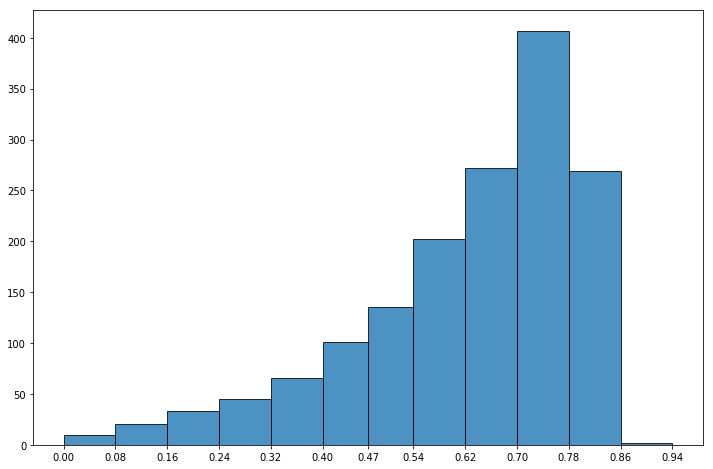

[  10.   20.   33.   45.   66.  101.  135.  202.  272.  407.  269.    2.]

The first 12 congestion window size is:
[  14480.   28960.   47784.   65160.   95568.  146248.  195480.  292496.
  393856.  589336.  389512.    2896.]


In [599]:
flow = flow_manager.get_flow(100)
print('Flow:', flow)

time_stamps = []
sender_port = getattr(flow, 'port1')
for packet in flow.flow:
    source_port = getattr(packet, 'source_port')
    if source_port == sender_port:
        time_stamp = getattr(packet, 'time_stamp')
        time_stamps.append(time_stamp)
        
start = time_stamps[0]
time_stamps.pop(0)  # delete the first hand shake SYN packet
time_stamps.pop(0)  # delete the third hand shake ACK packet

df_time = pd.DataFrame(time_stamps, columns=[['time_stamp']])
df_time = df_time - start

plt.figure(figsize=(12,8))
mybin = [0, 0.08, 0.16, 0.24, 0.32, 0.4, 0.47, 0.54, 0.62, 0.7, 0.78, 0.86, 0.94]
(counter, bins, patches) = plt.hist(df_time.time_stamp, bins=mybin, alpha=0.8, histtype='bar', ec='black')
plt.xticks(mybin)

plt.show()

print(counter)
print('\nThe first {} congestion window size is:'.format(len(counter)))
print(counter*1448)

## Second flow's Congestion Control

Flow: ID=101  port1=43500  port2=80  # of packets=11834


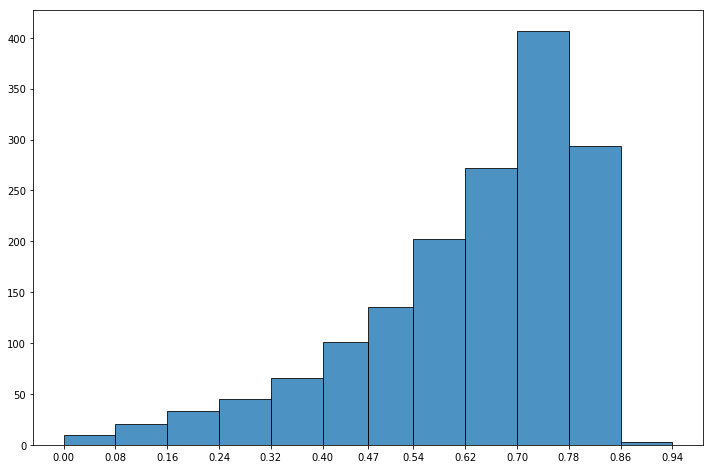

[  10.   20.   33.   45.   66.  101.  135.  202.  272.  407.  294.    3.]

The first 12 congestion window size is:
[  14480.   28960.   47784.   65160.   95568.  146248.  195480.  292496.
  393856.  589336.  425712.    4344.]


In [601]:
flow = flow_manager.get_flow(101)
print('Flow:', flow)

time_stamps = []
sender_port = getattr(flow, 'port1')
for packet in flow.flow:
    source_port = getattr(packet, 'source_port')
    if source_port == sender_port:
        time_stamp = getattr(packet, 'time_stamp')
        time_stamps.append(time_stamp)
        
start = time_stamps[0]
time_stamps.pop(0)  # delete the first hand shake SYN packet
time_stamps.pop(0)  # delete the third hand shake ACK packet

df_time = pd.DataFrame(time_stamps, columns=[['time_stamp']])
df_time = df_time - start

plt.figure(figsize=(12,8))
mybin = [0, 0.08, 0.16, 0.24, 0.32, 0.4, 0.47, 0.54, 0.62, 0.7, 0.78, 0.86, 0.94]
(counter, bins, patches) = plt.hist(df_time.time_stamp, bins=mybin, alpha=0.8, histtype='bar', ec='black')
plt.xticks(mybin)

plt.show()

print(counter)
print('\nThe first {} congestion window size is:'.format(len(counter)))
print(counter*1448)

## Third flow's Congestion Control

Flow: ID=102  port1=43502  port2=80  # of packets=1185


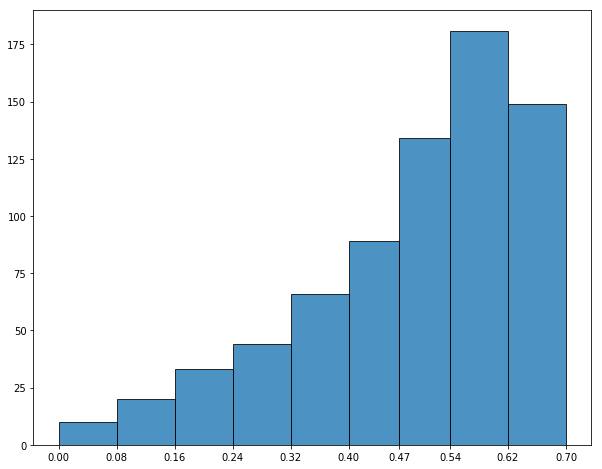

[  10.   20.   33.   44.   66.   89.  134.  181.  149.]

The first 9 congestion window size is:
[  14480.   28960.   47784.   63712.   95568.  128872.  194032.  262088.
  215752.]


In [605]:
flow = flow_manager.get_flow(102)
print('Flow:', flow)

time_stamps = []
sender_port = getattr(flow, 'port1')
for packet in flow.flow:
    source_port = getattr(packet, 'source_port')
    if source_port == sender_port:
        time_stamp = getattr(packet, 'time_stamp')
        time_stamps.append(time_stamp)
        
start = time_stamps[0]
time_stamps.pop(0)  # delete the first hand shake SYN packet
time_stamps.pop(0)  # delete the third hand shake ACK packet

df_time = pd.DataFrame(time_stamps, columns=[['time_stamp']])
df_time = df_time - start

plt.figure(figsize=(10,8))
mybin = [0, 0.08, 0.16, 0.24, 0.32, 0.4, 0.47, 0.54, 0.62, 0.7]
(counter, bins, patches) = plt.hist(df_time.time_stamp, bins=mybin, alpha=0.8, histtype='bar', ec='black')
plt.xticks(mybin)

plt.show()

print(counter)
print('\nThe first {} congestion window size is:'.format(len(counter)))
print(counter*1448)

### Note that in the ninth RTT, the sender finished sending its data, thus the flow ends without utilizing its full potential. This casues the ninth window is smaller than the eighth window. However, real congestion window size (full potential) of the ninth window is estimated around 230.

In [606]:
dic = {
    1:['caitao', 'zhan']
}

In [607]:
dic.get(1)

['caitao', 'zhan']